In [1]:
%load_ext autoreload
%autoreload 2
!RUST_BACKTRACE=1 cargo run -- ../models/quadrotor.mo -t ../templates/sympy.jinja > quadrotor_sympy.py

    Finished `dev` profile [unoptimized + debuginfo] target(s) in 0.08s
     Running `/home/jgoppert/git/rumoca_parol/target/debug/rumoca ../models/quadrotor.mo -t ../templates/sympy.jinja`


In [2]:
import quadrotor_sympy
import numpy as np
import matplotlib.pyplot as plt
import control

model = quadrotor_sympy.Model()
model.solve()
model.sol_x_dot

Matrix([
[                                                                                                                                                                                                                                                                                                          U*cos(psi)*cos(theta) + V*sin(phi)*sin(theta)*cos(psi) - V*sin(psi)*cos(phi) + W*sin(phi)*sin(psi) + W*sin(theta)*cos(phi)*cos(psi)],
[                                                                                                                                                                                                                                                                                                          U*sin(psi)*cos(theta) + V*sin(phi)*sin(psi)*sin(theta) + V*cos(phi)*cos(psi) - W*sin(phi)*cos(psi) + W*sin(psi)*sin(theta)*cos(phi)],
[                                                                                                                            

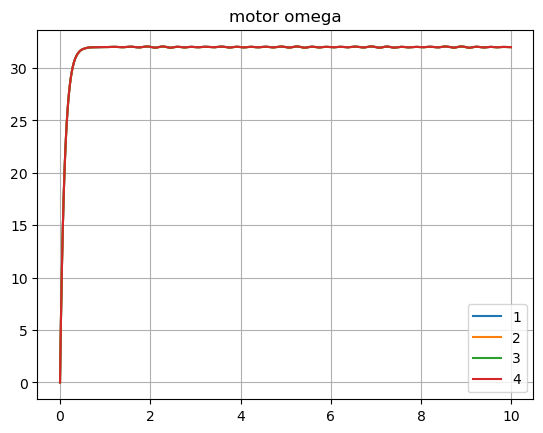

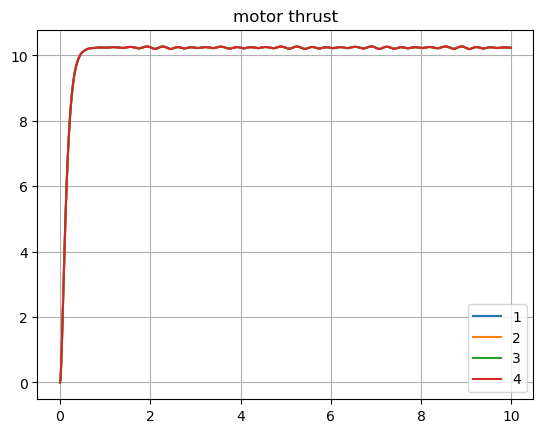

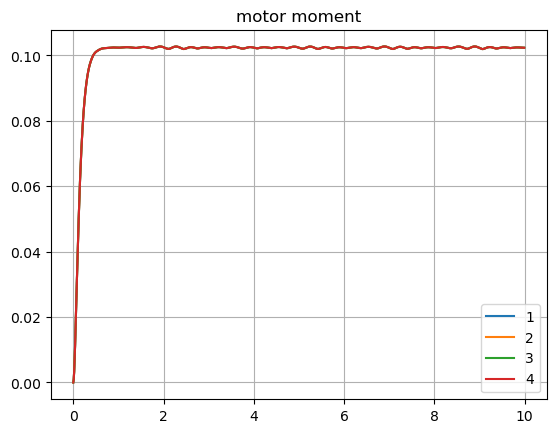

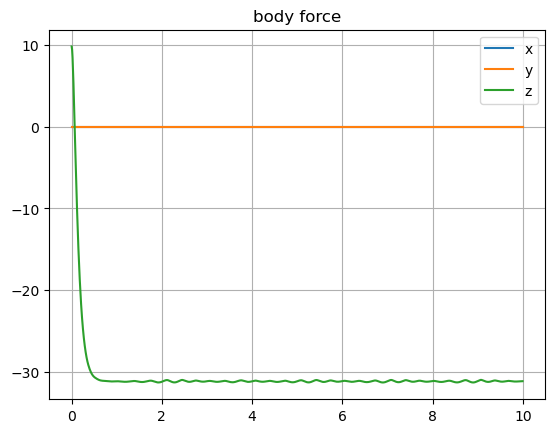

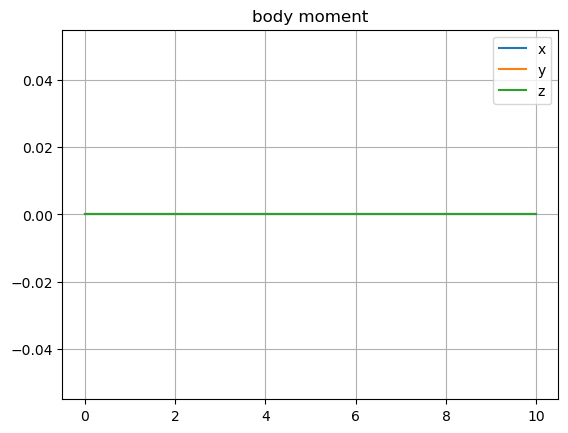

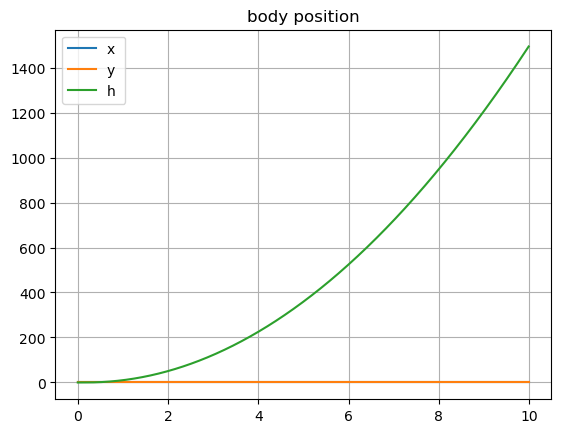

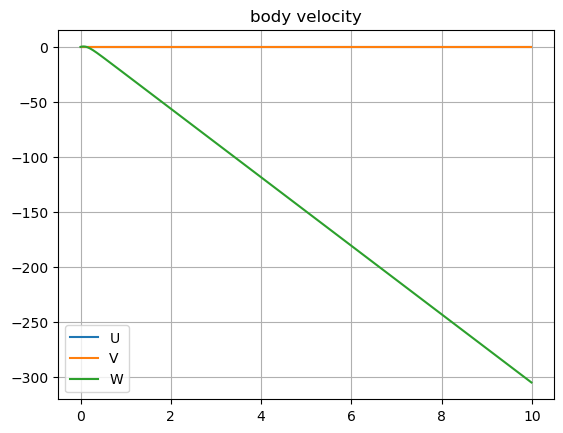

In [3]:
def f_u(t):
    # aileron, elevator, rudder, throttle
    return np.array([0, 0, 0, 1])

x0 = np.zeros(len(model.x))
model.p0['m_1_tau'] = 0.1
model.p0['m_2_tau'] = 0.1
model.p0['m_3_tau'] = 0.1
model.p0['m_4_tau'] = 0.1

res = model.simulate(t0=0, tf=10, dt=0.01, f_u=f_u, x0=x0)

plt.figure()
plt.plot(res['t'], res['x'][12:16, :].T, label=['1', '2', '3', '4']);
plt.grid()
plt.title('motor omega')
plt.legend()

plt.figure()
plt.plot(res['t'], res['y'][[
        model.y_index['m_1_thrust'],
        model.y_index['m_2_thrust'],
        model.y_index['m_3_thrust'],
        model.y_index['m_4_thrust'],
    ], :].T, label=['1', '2', '3', '4']);
plt.grid()
plt.title('motor thrust')
plt.legend()

plt.figure()
plt.plot(res['t'], res['y'][[
        model.y_index['m_1_moment'],
        model.y_index['m_2_moment'],
        model.y_index['m_3_moment'],
        model.y_index['m_4_moment'],
    ], :].T, label=['1', '2', '3', '4']);
plt.grid()
plt.title('motor moment')
plt.legend()

plt.figure()
plt.plot(res['t'], res['y'][[
        model.y_index['F_x'],
        model.y_index['F_y'],
        model.y_index['F_z'],
    ], :].T, label=['x', 'y', 'z']);
plt.grid()
plt.title('body force')
plt.legend()

plt.figure()
plt.plot(res['t'], res['y'][[
        model.y_index['M_x'],
        model.y_index['M_y'],
        model.y_index['M_z'],
    ], :].T, label=['x', 'y', 'z'])
plt.grid()
plt.title('body moment')
plt.legend()


plt.figure()
plt.plot(res['t'], res['x'][[
        model.x_index['x'],
        model.x_index['y'],
        model.x_index['h'],
    ], :].T, label=['x', 'y', 'h '])
plt.grid()
plt.title('body position')
plt.legend()

plt.figure()
plt.plot(res['t'], res['x'][[
        model.x_index['U'],
        model.x_index['V'],
        model.x_index['W'],
    ], :].T, label=['U', 'V', 'W'])
plt.grid()
plt.title('body velocity')
plt.legend()

In [4]:
# linearization
model.u0['a'] = 0
model.u0['e'] = 0
model.u0['r'] = 0
model.u0['t'] = 1

model.x0['m_1_omega'] = 16
model.x0['m_2_omega'] = 16
model.x0['m_3_omega'] = 16
model.x0['m_4_omega'] = 16

A = model.sol_x_dot.jacobian(model.x).subs(model.x0).subs(model.p0).subs(model.u0)
B = model.sol_x_dot.jacobian(model.u).subs(model.x0).subs(model.p0).subs(model.u0)

# output
#C = model.sol_y.jacobian(model.x).subs(model.x0).subs(model.p0).subs(model.u0)
#D = model.sol_y.jacobian(model.u).subs(model.x0).subs(model.p0).subs(model.u0)

# state feedback
C = np.eye(len(model.x))
D = np.zeros((len(model.x), len(model.u)))

sys = control.ss(A, B, C, D)
tfm = control.ss2tf(sys)

def clean_tf(G, tol):
    G = control.minreal(G, tol)
    return control.tf(np.where(np.abs(G.num) < 1e-10, 0, G.num), np.where(np.abs(G.den) < 1e-10, 0, G.den))

G_h_t = clean_tf(tfm[model.x_index['h'], model.u_index['t']], 0.01)
G_h_t

2 states have been removed from the model


TransferFunction(array([409.6]), array([ 1., 10.,  0.,  0.]))

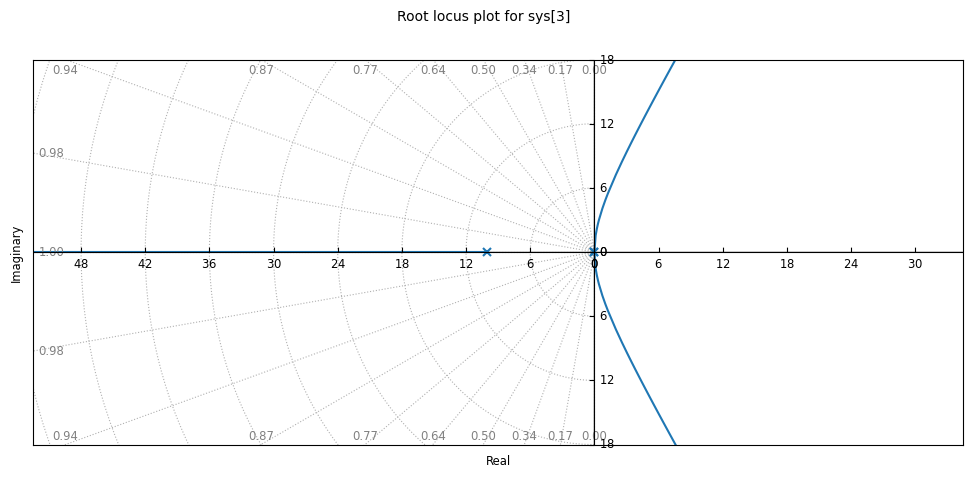

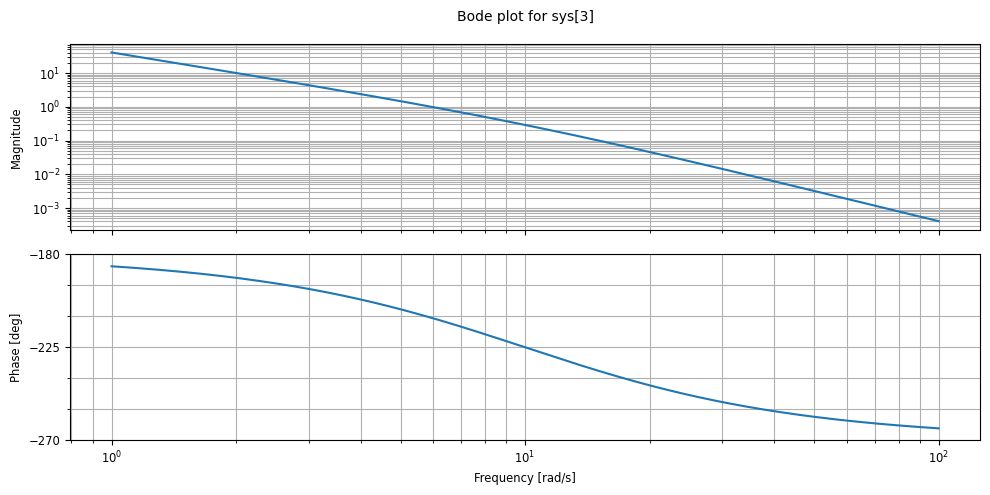

In [5]:
plt.figure(figsize=(12, 5))
control.rlocus(G_h_t)

plt.figure(figsize=(10, 5))
control.bode(G_h_t)

In [6]:
import rclpy
from rclpy.executors import SingleThreadedExecutor
from rclpy.node import Node
from sensor_msgs.msg import Joy
from rosgraph_msgs.msg import Clock
from builtin_interfaces.msg import Time
from geometry_msgs.msg import PoseStamped, TransformStamped
from tf2_ros import TransformBroadcaster
import numpy as np  # Ensure numpy is imported
import quadrotor_sympy
import tf_transformations
from geometry_msgs.msg import Quaternion

class QuadrotorNode(Node):
    def __init__(self, context):
        super().__init__(node_name='quadrotor_node', context=context)
        self.subscription = self.create_subscription(
            Joy,
            'joy',
            self.joy_callback,
            10
        )
        self.model = quadrotor_sympy.Model()
        self.tf_broadcaster = TransformBroadcaster(self)  # Initialize the TF2 broadcaster
        self.sim_time_publisher = self.create_publisher(Clock, '/clock', 10)  # Sim time publisher
        self.timer = self.create_timer(0.1, self.step_simulation)  # Timer to publish sim time

        self.sim_time = 0.0  # Initialize simulation time
        self.x0 = np.zeros(16)
        self.joy_aileron = 0
        self.joy_elevator = 0
        self.joy_rudder = 0
        self.joy_throttle = 0.5
        self.get_logger().info(f"Simulation started")

    def step_simulation(self):
        """Step the simulation."""
        # publish sim time
        self.sim_time += 0.1  # Increment simulation time by 0.1 seconds
        sim_time_msg = Clock()
        sim_time_msg.clock = Time()
        sim_time_msg.clock.sec = int(self.sim_time)
        sim_time_msg.clock.nanosec = int((self.sim_time - int(self.sim_time)) * 1e9)
        self.sim_time_publisher.publish(sim_time_msg)
        # self.get_logger().info(f"Published sim_time: {sim_time_msg.clock.sec}.{sim_time_msg.clock.nanosec}")
        
        u= np.array([
            self.joy_aileron,
            self.joy_elevator,
            self.joy_rudder,
            self.joy_throttle])
        
        res = self.model.simulate(t0=0, tf=0.1, dt=0.01, x0=self.x0, f_u=lambda t: u)
        self.x0 = res['x'][:, -1]

        q = tf_transformations.quaternion_from_euler(
            self.x0[9], # roll (same)
            -self.x0[10],  # pitch (inverted in ros)
            -self.x0[11], # inverted in ros
            )

        # Publish the transform
        transform = TransformStamped()
        transform.header.stamp = sim_time_msg.clock
        transform.header.frame_id = "map"
        transform.child_frame_id = "quadrotor"
        transform.transform.translation.x = self.x0[0]
        transform.transform.translation.y = -self.x0[1] # y coordinate flip
        transform.transform.translation.z = self.x0[2]
        transform.transform.rotation.x = q[0]
        transform.transform.rotation.y = q[1]
        transform.transform.rotation.z = q[2]
        transform.transform.rotation.w = q[3]
        self.tf_broadcaster.sendTransform(transform)

    def joy_callback(self, msg):
        self.joy_aileron = -0.1*msg.axes[3]
        self.joy_elevator = 0.1*msg.axes[4]
        self.joy_rudder = -1*msg.axes[0]
        self.joy_throttle = msg.axes[1]/2 + 0.6
        print(f"ail: {self.joy_aileron}, elv: {self.joy_elevator}, rdr: {self.joy_rudder}, thr: {self.joy_throttle}")

def run(args=None):
    # Create a scoped ROS 2 context
    context = rclpy.Context()
    try:
        context.init()
        executor = SingleThreadedExecutor(context=context)
        executor.add_node(QuadrotorNode(context=context))
        executor.spin()
    except KeyboardInterrupt:
        pass
    finally:
        print('simulation finished')
        context.try_shutdown()
        del executor
        del context

run()

[INFO] [1743902366.042606566] [quadrotor_node]: Simulation started


simulation finished


In  another terminal run:

```bash
ros2 run rviz2 rviz2 --ros-args -p use_sim_time:=true
```

Add quadrotor_pose to view.

In  another terminal run:

```bash
ros2 run joy joy_node --ros-args -p use_sim_time:=true
```
